In [1]:
import nibabel as nib
import os
import scipy.io as sio
from nilearn import plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# import pylab

In [2]:
# load minimally processed fMRI data
# should be registered to MNI152 2mm

sub_id = '707749'
scan_id = 'REST1_LR'
proc = 'min'

if proc == 'fix':
    fname = '/bigdata/HCP_rest/bad_samples/raw/'+ sub_id +'/fMRI/' + proc + '/rfMRI_' + scan_id + '_hp2000_clean.nii.gz'
else:
    fname = '/bigdata/HCP_rest/bad_samples/raw/'+ sub_id +'/fMRI/' + proc + '/rfMRI_' + scan_id + '.nii.gz'
print(fname)

# load raw (not blurred) scan 
subj_scan = nib.load(fname)
fmri = subj_scan.get_fdata()

# save the procesed data to the path
out_path = '/bigdata/HCP_rest/bad_samples/processed/' + proc + '/extracted/'

/bigdata/HCP_rest/bad_samples/raw/707749/fMRI/min/rfMRI_REST1_LR.nii.gz


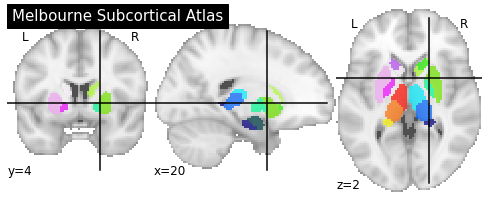

/bigdata/HCP_rest/bad_samples/processed/min/extracted/tian/rois_707749_rfMRI_REST1_LR.mat


In [3]:
# load subcortical atlas
# this atlas is single 3d volume with varying labels (non-overlapping)

atlas_path = '/data/gm-atlases/Tian2020MSA/7T_2mm/Tian_Subcortex_S1_7T_2mm.nii.gz'

atlas_name = 'tian'

atlas = nib.load(atlas_path)
affine = atlas.affine
volume = atlas.get_fdata()

# plot atlas
new_img = nib.Nifti1Image(volume, affine)
plotting.plot_roi(new_img, title='Melbourne Subcortical Atlas')
plt.show()

subcor_ts = []
for i in np.unique(volume):
    if i != 0: 
        bool_roi = np.zeros(volume.shape, dtype=int)
        bool_roi[volume == i] = 1
        bool_roi = bool_roi.astype(np.bool)
        
        # extract time-series data for each roi
        roi_ts_mean = []
        for t in range(fmri.shape[-1]):
            roi_ts_mean.append(np.mean(fmri[:, :, :, t][bool_roi]))
        
        subcor_ts.append(np.array(roi_ts_mean))
        
Y = np.array(subcor_ts).T
Y_dict = {'Y': Y}

fname = out_path + atlas_name + '/rois_' + sub_id + '_rfMRI_' + scan_id + '.mat'
sio.savemat(fname, Y_dict)
print(fname)

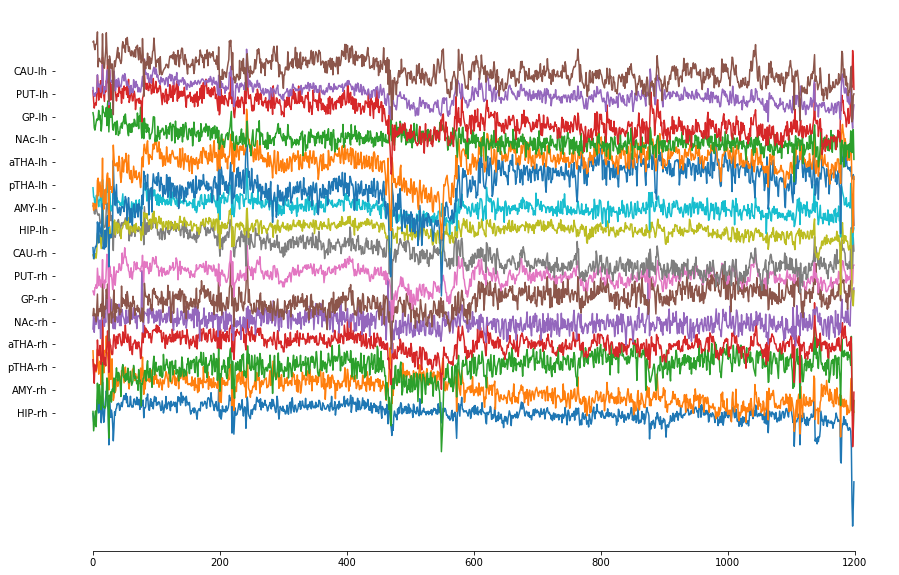

In [4]:
# VISUALIZE

# load labels
label_file = '/data/gm-atlases/Tian2020MSA/3T/Subcortex-Only/Tian_Subcortex_S1_3T_label.txt'
with open(label_file) as f:
    labels = [line.strip('\n') for line in f.readlines()]

# demean and offset for visualization purposes only
Yd = Y-np.mean(Y, axis=0)

# add offset (space the y-axis appropriately for visual inspection - no longer the accurate values)
offset = 300 #points
Y_do = np.zeros(Y.shape)
for i in range(len(labels)):
    Y_do[: , i] = Yd[:, i] + i*offset

# plot extracted time-series signals
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(Y_do)

# show labels
ax.set_yticks(np.mean(Y_do, axis=0))
ax.set_yticklabels(labels)

sns.despine(left=True, trim=True)
plt.show()

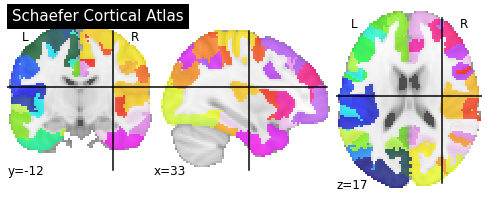

/bigdata/HCP_rest/bad_samples/processed/min/extracted/schaefer/rois_707749_rfMRI_REST1_LR.mat


In [5]:
# load cortical atlas
# this atlas is single 3d volume with varying labels (non-overlapping)

atlas_path = '/data/gm-atlases/Schaefer/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2mm.nii.gz'

atlas = nib.load(atlas_path)
affine = atlas.affine
volume = atlas.get_fdata()

atlas_name = 'schaefer'

# plot atlas
new_img = nib.Nifti1Image(volume, affine)
plotting.plot_roi(new_img, title='Schaefer Cortical Atlas')
plt.show()

subcor_ts = []
for i in np.unique(volume):
    if i != 0: 
        bool_roi = np.zeros(volume.shape, dtype=int)
        bool_roi[volume == i] = 1
        bool_roi = bool_roi.astype(np.bool)
        
        # extract time-series data for each roi
        roi_ts_mean = []
        for t in range(fmri.shape[-1]):
            roi_ts_mean.append(np.mean(fmri[:, :, :, t][bool_roi]))
        
        subcor_ts.append(np.array(roi_ts_mean))
        
Y = np.array(subcor_ts).T
Y_dict = {'Y': Y}

fname = out_path + atlas_name + '/rois_' + sub_id + '_rfMRI_' + scan_id + '.mat'
sio.savemat(fname, Y_dict)
print(fname)

In [6]:
# load white matter atlas
# this atlas is probabilistic and 4D (overlapping ROIs)

wm_path = '/data/wm-atlases/pandora_2mm/'
wm_method = os.path.join(wm_path + 'TractSeg_2mm_HCP.nii.gz')
wm_atlas = nib.load(wm_method)
wm = wm_atlas.get_fdata()

atlas_name = 'tractseg'

# convert the probabilistic map to binary
th = 0.95
th_wm = np.zeros(wm.shape)
th_wm[wm > th] = 1
th_wm[wm <= th] = 0

del wm, wm_atlas

wm_ts = []
for i in range(th_wm.shape[3]):
    pathway = th_wm[:, :, :, i]
    pathway = pathway.astype(np.bool)

    # extract time-series data for each roi
    roi_ts_mean = []
    for t in range(fmri.shape[-1]):
        roi_ts_mean.append(np.mean(fmri[:, :, :, t][pathway]))

    wm_ts.append(np.array(roi_ts_mean))

Y = np.array(wm_ts).T
Y_dict = {'Y': Y}

fname = out_path + atlas_name + '/rois_' + sub_id + '_rfMRI_' + scan_id + '.mat'
sio.savemat(out_path + atlas_name + '/rois_' + sub_id + '_rfMRI_' + scan_id + '.mat', Y_dict)
print(fname)

/bigdata/HCP_rest/bad_samples/processed/min/extracted/tractseg/rois_707749_rfMRI_REST1_LR.mat


In [7]:
# load brainstem atlas
# this atlas has separate 3D nii images for each ROI (non-overlapping)

atlas_path = '/data/AAN_brainstem_2mm'
atlas_dir = sorted(os.listdir(atlas_path))

atlas_name = 'aan'

stem_ts = []

for file in atlas_dir:
    roi = os.path.join(atlas_path, file)
    atlas = nib.load(roi)
    affine = atlas.affine
    volume = atlas.get_fdata()

    bool_roi = np.zeros(volume.shape)
    bool_roi[volume > 0] = 1
    bool_roi = bool_roi.astype(np.bool)

    # extract time-series data for each roi
    roi_ts_mean = []
    for t in range(fmri.shape[-1]):
        roi_ts_mean.append(np.mean(fmri[:, :, :, t][bool_roi]))

    stem_ts.append(np.array(roi_ts_mean))

Y = np.array(stem_ts).T
Y_dict = {'Y': Y}

fname = out_path + atlas_name + '/rois_' + sub_id + '_rfMRI_' + scan_id + '.mat'
sio.savemat(out_path + atlas_name + '/rois_' + sub_id + '_rfMRI_' + scan_id + '.mat', Y_dict)
print(fname)

/bigdata/HCP_rest/bad_samples/processed/min/extracted/aan/rois_707749_rfMRI_REST1_LR.mat


In [8]:
print('HOORAY! \n\nExtracted time-series signals using 4 atlases.')

HOORAY! 

Extracted time-series signals using 4 atlases.
